# Работа со сложными данными и обучение без учителя

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
                                    LabelEncoder, OneHotEncoder, label_binarize, OrdinalEncoder, 
                                    StandardScaler, QuantileTransformer, PowerTransformer, MinMaxScaler, RobustScaler
                                  )

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve,
                             precision_recall_curve, classification_report, recall_score, precision_score,
                             log_loss, brier_score_loss)

from category_encoders import TargetEncoder, WOEEncoder, HashingEncoder

In [236]:
df = pd.read_csv('Churn_Modelling.csv')

In [237]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [239]:
RANDOM_STATE = 177013

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Exited'], axis=1),
                                                    df['Exited'],
                                                    test_size=0.2,
                                                    random_state=177013,
                                                    shuffle=True,
                                                    stratify=df['Exited']
                                                    )

## Кодирование категорий

### One-Hot encoding

Простой и универсальный метод: каждое возможное значение можно описать бинарным признаком. Для N значений достаточно N-1 таких признаков.

Для всего датасета через pandas:

In [7]:
pd.get_dummies(X_train['Geography'], drop_first=True)

,Germany,Spain
1952,True,False
2819,False,False
7270,True,False
9614,False,False
7773,True,False
...,...,...
4680,True,False
2429,False,False
8630,True,False
8533,False,False


Если у вас отдельные сеты, метод из pandas ненадежен, поскольку не гарантируется, что везде присутствуют все возможные значения.

Через sklearn:

In [8]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
encoder.fit_transform(X_train[['Geography']])

,Geography_Germany,Geography_Spain
1952,1.0,0.0
2819,0.0,0.0
7270,1.0,0.0
9614,0.0,0.0
7773,1.0,0.0
...,...,...
4680,1.0,0.0
2429,0.0,0.0
8630,1.0,0.0
8533,0.0,0.0


### Label encoding

Если порядок категорий имеет смысл, можно закодировать их числами по возрастанию. Деревянные модели неплохо понимают такое кодирование, а вот для прочих использовать его не стоит.

Кодирование в алфавитном порядке:

In [9]:
encoder = OrdinalEncoder()
X_train['geo_encoded'] = encoder.fit_transform(X_train[['Geography']])
X_train[['Geography', 'geo_encoded']].head()

,Geography,geo_encoded
1952,Germany,1.0
2819,France,0.0
7270,Germany,1.0
9614,France,0.0
7773,Germany,1.0


Кодирование в порядке появления:

In [10]:
X_train['geo_encoded'], uniques = pd.factorize(X_train['Geography'])
X_train[['Geography', 'geo_encoded']].head()

,Geography,geo_encoded
1952,Germany,0
2819,France,1
7270,Germany,0
9614,France,1
7773,Germany,0


В произвольном порядке:

In [11]:
X_train['geo_encoded'] = label_binarize(X_train['Geography'], classes=['Germany', 'France', 'Spain']).argmax(axis=1)
X_train[['Geography', 'geo_encoded']].head()

,Geography,geo_encoded
1952,Germany,0
2819,France,1
7270,Germany,0
9614,France,1
7773,Germany,0


### Frequency encoding

In [12]:
X_train['geo_encoded'] = st.rankdata(X_train['Geography'], method='average')
X_train[['Geography', 'geo_encoded']].head()

,Geography,geo_encoded
1952,Germany,5027.5
2819,France,2013.5
7270,Germany,5027.5
9614,France,2013.5
7773,Germany,5027.5


### Weight of evidence

Предназначен для задачи бинарной классификации. По сути является логарифмом отношения долей положительного и отрицательного класса для данного значения категории.

In [13]:
encoder = WOEEncoder()
X_train['geo_encoded'] = encoder.fit_transform(X_train['Geography'], y_train)
X_train[['Geography', 'geo_encoded']].head(10)

,Geography,geo_encoded
1952,Germany,0.614566
2819,France,-0.280466
7270,Germany,0.614566
9614,France,-0.280466
7773,Germany,0.614566
7671,France,-0.280466
6946,France,-0.280466
9457,France,-0.280466
4094,France,-0.280466
6225,Germany,0.614566


**Этот метод использует целевой признак! Фитить его следует только на обучающей выборке после разбиения!**

### Mean-target encoding

Заменяет категорию на среднее значение целевого признака по этой категории. Хорошо подходит для случаев большой кардинальности, однако следует быть осторожным в плане утечки целевого признака для очень редких категорий. В `category_encoders` есть более робастные реализации, например, `LeaveOneOutEncoder()`.

In [14]:
encoder = TargetEncoder()
X_train['geo_encoded'] = encoder.fit_transform(X_train['Geography'], y_train)
X_train[['Geography', 'geo_encoded']].head(10)

,Geography,geo_encoded
1952,Germany,0.321179
2819,France,0.161947
7270,Germany,0.321179
9614,France,0.161947
7773,Germany,0.321179
7671,France,0.161947
6946,France,0.161947
9457,France,0.161947
4094,France,0.161947
6225,Germany,0.321179


**Этот метод использует целевой признак! Фитить его следует только на обучающей выборке после разбиения!**

### Хеширование

Этот метод подходит, если категорий много, но некоторая потеря информации допустима.

In [15]:
encoder = HashingEncoder()
encoder.fit_transform(X_train['Geography']).head(10)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
1952,0,0,0,0,0,0,0,1
2819,0,1,0,0,0,0,0,0
7270,0,0,0,0,0,0,0,1
9614,0,1,0,0,0,0,0,0
7773,0,0,0,0,0,0,0,1
7671,0,1,0,0,0,0,0,0
6946,0,1,0,0,0,0,0,0
9457,0,1,0,0,0,0,0,0
4094,0,1,0,0,0,0,0,0
6225,0,0,0,0,0,0,0,1


Более подробную блок-схему выбора метода для кодировки можно найти на https://innovation.alteryx.com/encode-smarter/

### Кодирование внутри конвейера

In [16]:
cat_columns = ['Geography', 'Gender']
useless_columns = ['CustomerId', 'RowNumber', 'Surname', 'geo_encoded']

In [17]:
# Предобработка по группам признаков:
transformers = [
                    ("encoder", OneHotEncoder(drop='first'), cat_columns),
                    ("drop", "drop", useless_columns),
               ]

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1)

In [18]:
def optimize(model, params, X, y):
    name = f'{type(model).__name__}'
    print(f'Оптимизация {name}...')
    pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('scaler', None),                
                        ('model', model)
                    ])
    gcv = GridSearchCV(pipe, params, cv=4, scoring='neg_log_loss', n_jobs=-1)
    gcv.fit(X, y)
    print(f'Лучшие гиперпараметры: {dict(gcv.best_params_)}')
    print(f'Скор: {(-gcv.best_score_):.2f}')
    return gcv.best_estimator_

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [20]:
boost_params = {
                    'model__max_depth' : range(1, 10),
                    'model__max_iter' : [200, 500, 1000],
                }

In [21]:
best_hgb = optimize(HistGradientBoostingClassifier(random_state=RANDOM_STATE), boost_params, X_train, y_train)

Оптимизация HistGradientBoostingClassifier...
Лучшие гиперпараметры: {'model__max_depth': 3, 'model__max_iter': 200}
Скор: 0.34


In [22]:
def calculate_metrics(target_test, probabilities):
    cmatrix = confusion_matrix(target_test, probabilities > 0.5)

    ap = average_precision_score(target_test, probabilities)
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    roc_auc = roc_auc_score(target_test, probabilities)

    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f_scores = 2 * recall * precision / (recall + precision)
    f_scores = np.nan_to_num(f_scores)
    best_thresh = thresholds[np.argmax(f_scores)]
    best_f = np.max(f_scores)
    best_acc = accuracy_score(target_test, (probabilities > best_thresh))
    best_cmatrix = confusion_matrix(target_test, (probabilities > best_thresh))

    return best_f, roc_auc, best_acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

In [23]:
def visualize(target_test, probabilities):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    best_f, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics(target_test, probabilities)
    print(f'ROC_AUC: {roc_auc:.2f}, AP (PR_AUC): {ap:.2f}, наилучший F1: {best_f:.2f} с порогом {best_thresh:.2f} (accuracy {acc:.2f})')
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);

    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC-кривая', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR-кривая', xlim=(0,1), ylim=(0,1))
    plt.show()
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.heatmap(cmatrix, ax=axes[0], annot=True, cmap='Blues', fmt='d').set(title='Матрица ошибок', xlabel='Предсказание', ylabel='Реальность')
    sns.heatmap(best_cmatrix, ax=axes[1], annot=True, cmap='Blues', fmt='d').set(title='Матрица ошибок (оптимальный порог)', xlabel='Предсказание', ylabel='Реальность')

    
    return best_thresh

ROC_AUC: 0.87, AP (PR_AUC): 0.71, наилучший F1: 0.63 с порогом 0.35 (accuracy 0.85)


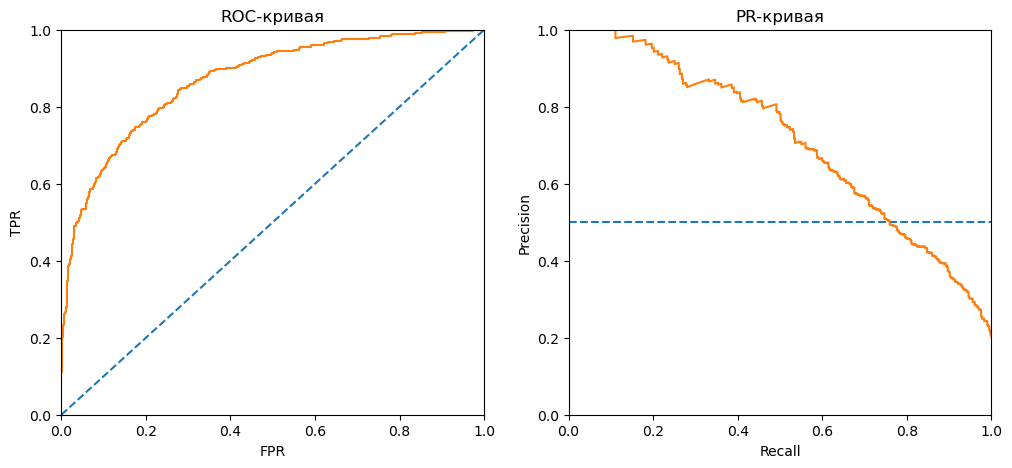

0.35499114731451187

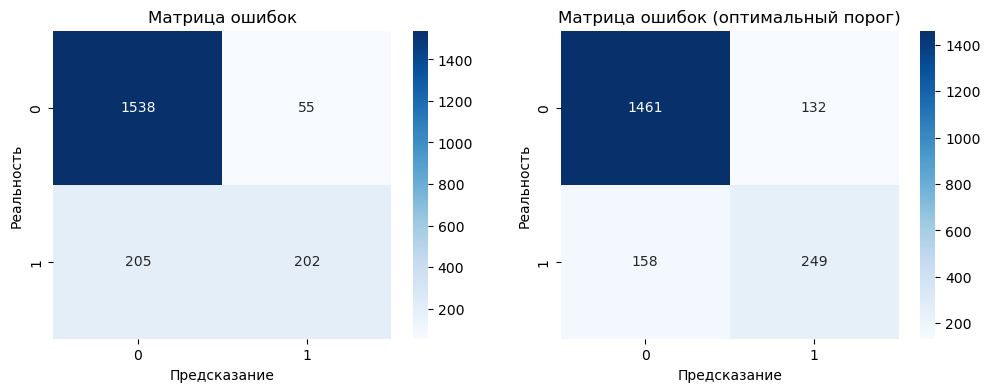

In [24]:
visualize(y_test, best_hgb.predict_proba(X_test)[:,1])

In [25]:
encoder_list = [
                OneHotEncoder(drop='first'),
                OrdinalEncoder(),
                WOEEncoder(),
                TargetEncoder(),
               ]

In [26]:
boost_params = {
                    'preprocessor__encoder' : encoder_list, 
                    'model__max_depth' : range(1, 10),
                    'model__max_iter' : [200, 500, 1000],
                }

In [27]:
best_hgb = optimize(HistGradientBoostingClassifier(random_state=RANDOM_STATE), boost_params, X_train, y_train)

Оптимизация HistGradientBoostingClassifier...
Лучшие гиперпараметры: {'model__max_depth': 3, 'model__max_iter': 200, 'preprocessor__encoder': OneHotEncoder(drop='first')}
Скор: 0.34


## Простое кодирование текстов

Воспользуемся датасетом твитов о стихийных бедствиях и катастрофах:

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

In [29]:
df = pd.read_csv('disaster_tweets.csv')

In [30]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [32]:
df['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [33]:
text_columns = 'text'
useless_columns = ['id', 'keyword', 'location']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=177013,
                                                    shuffle=True,
                                                    stratify=df['target']
                                                    )

### Bag of words

Самый простой способ - найти все уникальные слова и выделить бинарный признак на наличие каждого в тексте.

Недостатки достаточно очевидные:

- совершенно не учитывается порядок слов;
- уникальных слов может быть много - придется урезать число новых признаков в пользу самых частых.

Тем не менее, во многих случаях этот способ неплохо работает! В sklearn он представлен `sklearn.feature_extraction.text.CountVectorizer()`. При желании можно даже провести обратное преобразование и найти ключевые слова с помощью feature importance.

Чуть более быстрый способ - `HashingVectorizer()`, у него обратного преобразования нет, но как небольшой плюс он масштабирует признаки на выходе.

In [35]:
# Предобработка по группам признаков:
transformers = [
                    ("encoder", CountVectorizer(max_features=500), text_columns),
                    ("drop", "drop", useless_columns),
               ]

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1, sparse_threshold=0)

In [36]:
def optimize(model, params, X, y):
    name = f'{type(model).__name__}'
    print(f'Оптимизация {name}...')
    pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('scaler', None),                
                        ('model', model)
                    ])
    gcv = GridSearchCV(pipe, params, cv=4, scoring='neg_log_loss', n_jobs=-1)
    gcv.fit(X, y)
    print(f'Лучшие гиперпараметры: {dict(gcv.best_params_)}')
    print(f'Скор: {(-gcv.best_score_):.2f}')
    return gcv.best_estimator_

In [37]:
# Список скейлеров:
scaler_list = [
               StandardScaler(),
               PowerTransformer(),
               QuantileTransformer(random_state=RANDOM_STATE),
               QuantileTransformer(random_state=RANDOM_STATE, output_distribution='normal'),
              ]

In [38]:
encoder_list = [
                    CountVectorizer(max_features=500, stop_words='english'),
                    #CountVectorizer(max_features=500, ngram_range=(1,2)),
                    HashingVectorizer(n_features=500, stop_words='english'),
                    TfidfVectorizer(max_features=500, stop_words='english'),
               ]

In [39]:
lr_params = {
                    #'preprocessor__encoder':encoder_list,
                    'scaler':scaler_list,
                    'model__C':np.logspace(-3, 3, 7),
              }

In [40]:
best_lr = optimize(LogisticRegression(solver='newton-cholesky', random_state=RANDOM_STATE, n_jobs=-1), lr_params, X_train, y_train)

Оптимизация LogisticRegression...
Лучшие гиперпараметры: {'model__C': 0.01, 'scaler': QuantileTransformer(output_distribution='normal', random_state=177013)}
Скор: 0.48


ROC_AUC: 0.82, AP (PR_AUC): 0.82, наилучший F1: 0.73 с порогом 0.43 (accuracy 0.77)


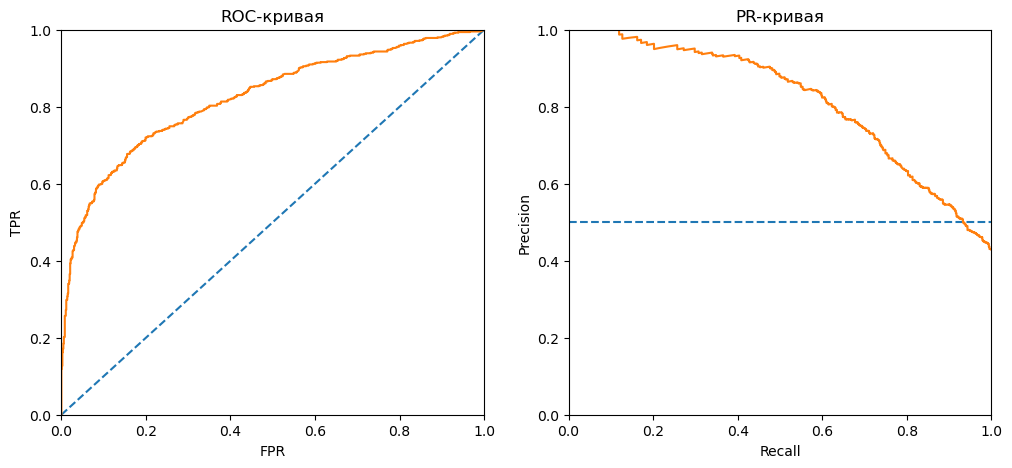

0.4290131079508451

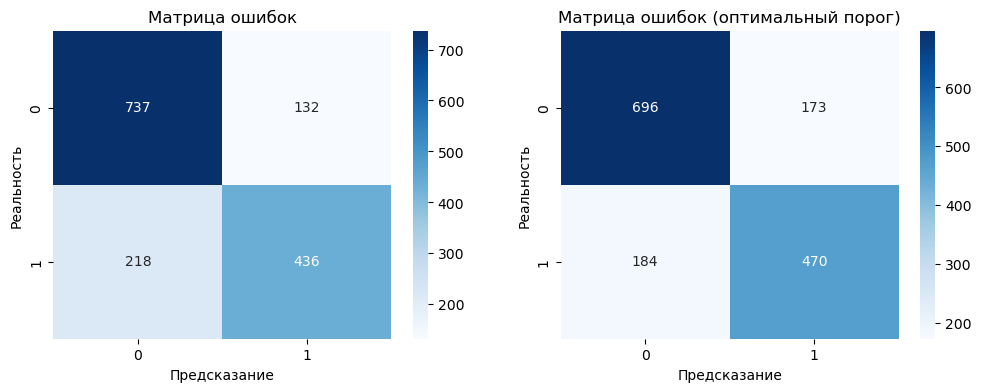

In [41]:
visualize(y_test, best_lr.predict_proba(X_test)[:,1])

In [42]:
mdi_importances = pd.Series(best_lr['model'].coef_[0], index=best_lr[:-1].get_feature_names_out())

In [43]:
mdi_importances.sort_values(ascending=False).head(10)

encoder__hiroshima     0.267682
encoder__typhoon       0.260038
encoder__derailment    0.245536
encoder__spill         0.242346
encoder__earthquake    0.228663
encoder__floods        0.221074
encoder__wildfire      0.213689
encoder__debris        0.205834
encoder__bombing       0.204214
encoder__casualties    0.204015
dtype: float64

#### N-grams

Можно строить признаки не только на отдельных словах, но и на словах, встречающихся в паре (или в более длинной последовательности). Для этого достаточно воспользоваться параметром `ngram_range`, например вот так:

In [44]:
CountVectorizer(max_features=200, ngram_range=(2,2))

CountVectorizer(max_features=200, ngram_range=(2, 2))

### TF-IDF

Этот способ учитывает употребление слова как в конкретной записи, так и во всем столбце.

Term Frequency:

$$
TF = \frac{t}{n}
$$

$t$ - число повторов слова в тексте, $n$ - длина текста

Inverse Document Frequency:

$$
IDF = log_{10}\frac{D}{d}
$$

$D$ - общее число текстов, $d$ - число текстов, где слово встречается.

Реализован в `TfidfVectorizer()`.

### Самостоятельная работа

Измените гиперпараметры выше, чтобы обучить модель на биграмах (можно использовать любой векторайзер). Стало ли лучше? Как думаете, почему?

## Предобработка текста

Для классических методов нам желательно не включать ничего лишнего в данные, чтобы получить рабочее и компактное преобразование. В этом могут помочь:

- удаление пунктуации;
- чистка от специфического мусора (гиперссылки, эмодзи и т. п.);
- задание списка стоп-слов, которые встречаются часто, но мало добавляют к смыслу (артиклей, предлогов, местоимений...);
- лемматизация (приведение слова к словарной форме);
- стемминг (выделение основы слова).

Основные библиотеки для исследования и обработки текстов:

- NLTK
- spaCy
- gensim
- TextBlob

На примере библиотеки gensim:

In [45]:
sentence = X_train['text'].iloc[9]
sentence

'@Durban_Knight Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carr... http://t.co/cWCVBuBs01 @Nosy_Be'

In [46]:
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_non_alphanum

In [47]:
strip_non_alphanum(sentence)

' Durban_Knight Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carr    http   t co cWCVBuBs01  Nosy_Be'

In [48]:
remove_stopwords(sentence)

'@Durban_Knight Rescuers searching hundreds migrants Mediterranean boat carr... http://t.co/cWCVBuBs01 @Nosy_Be'

In [49]:
from gensim.parsing.porter import PorterStemmer
p = PorterStemmer()
p.stem_sentence(sentence)

'@durban_knight rescuer ar search for hundr of migrant in the mediterranean after a boat carr... http://t.co/cwcvbubs01 @nosy_b'

### Токенизация

Наконец, для обработки предложение надо разбить на список слов (векторайзеры из sklearn делают это сами, но им можно указать свои функции для предобработки и токенизации). В большинстве случаев достаточно `split()`, но если надо, например, сохранить пунктуацию, процесс усложняется.

`preprocess_string()` из gensim - один из вариантов пакетной обработки, от чистки до стемминга и токенизации:

In [50]:
preprocess_string(sentence)

['durban',
 'knight',
 'rescuer',
 'search',
 'hundr',
 'migrant',
 'mediterranean',
 'boat',
 'carr',
 'http',
 'cwcvbub',
 'nosi']

Библиотеки, предоставляющие лемматизацию: https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

In [51]:
def clean(text):
    return ' '.join(preprocess_string(text))

In [52]:
lr_params = {
                    'preprocessor__encoder':[CountVectorizer(max_features=500, preprocessor=clean)],
                    'scaler':scaler_list,
                    'model__C':np.logspace(-3, 3, 7),
              }

In [53]:
best_lr = optimize(LogisticRegression(solver='newton-cholesky', random_state=RANDOM_STATE, n_jobs=-1), lr_params, X_train, y_train)

Оптимизация LogisticRegression...
Лучшие гиперпараметры: {'model__C': 0.01, 'preprocessor__encoder': CountVectorizer(max_features=500,
                preprocessor=<function clean at 0x7efe6ae4e320>), 'scaler': QuantileTransformer(output_distribution='normal', random_state=177013)}
Скор: 0.47


ROC_AUC: 0.83, AP (PR_AUC): 0.82, наилучший F1: 0.73 с порогом 0.45 (accuracy 0.77)


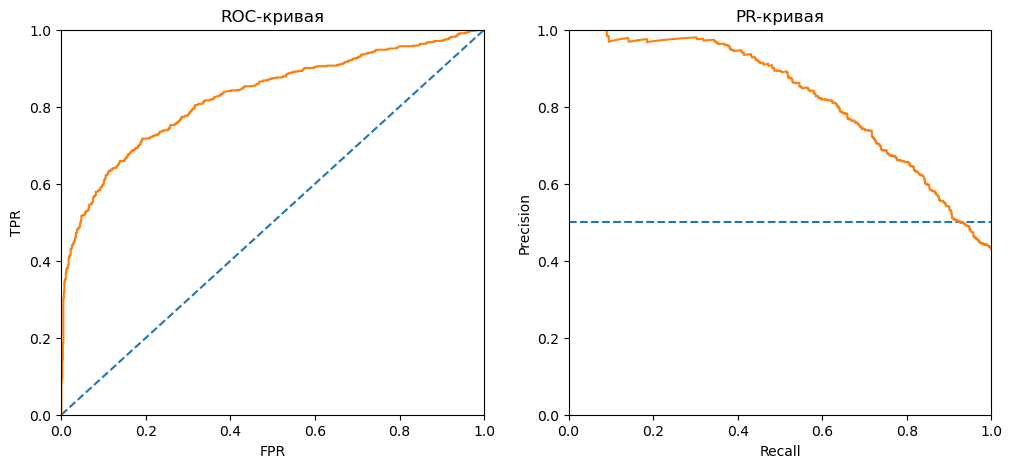

0.45145897022111653

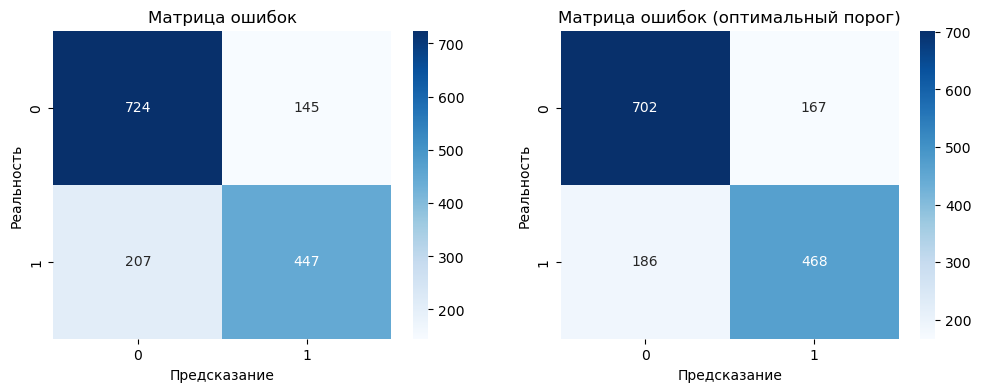

In [54]:
visualize(y_test, best_lr.predict_proba(X_test)[:,1])

## Word2Vec (на примере gensim)

In [55]:
from gensim.models import Word2Vec

import gensim.downloader as api

Можно обучить Word2Vec на наших данных, но результат будет так себе. Для качественных эмбеддингов требуется большой корпус данных.

In [56]:
embeddings_trained = Word2Vec(
                                X_train['text'].apply(preprocess_string),
                                vector_size=100,
                                min_count=25,
                                window=25,
                                workers=-1,
                             ).wv

К счастью, предобученных моделей много в свободном доступе:

In [57]:
model_glove_twitter = api.load("glove-twitter-100")

### Свойства векторов эмбеддингов

In [58]:
for key, similarity in model_glove_twitter.similar_by_word('cat')[:5]:
    print(f"{key}: {similarity:.2f}")

dog: 0.88
kitty: 0.80
pet: 0.80
cats: 0.80
kitten: 0.79


In [59]:
new_vector = model_glove_twitter['kitten'] - model_glove_twitter['cat'] +  model_glove_twitter['dog']

In [60]:
for key, similarity in model_glove_twitter.similar_by_vector(new_vector)[:1]:
    print(f"{key}: {similarity:.2f}")

puppy: 0.88


In [61]:
model_glove_twitter.most_similar(positive=['kitten', 'dog'], negative=['cat'])

[('puppy', 0.8719636797904968),
 ('puppies', 0.7556495666503906),
 ('dogs', 0.7449606657028198),
 ('kittens', 0.7280494570732117),
 ('pug', 0.7214158773422241),
 ('pups', 0.7083081007003784),
 ('stray', 0.6989467740058899),
 ('cats', 0.6754456758499146),
 ('yorkie', 0.6696217060089111),
 ('munchkin', 0.6682391166687012)]

### Совместимость предобработки

In [62]:
list(model_glove_twitter.key_to_index)[:20]

['<user>',
 '.',
 ':',
 'rt',
 ',',
 '<repeat>',
 '<hashtag>',
 '<number>',
 '<url>',
 '!',
 'i',
 'a',
 '"',
 'the',
 '?',
 'you',
 'to',
 '(',
 '<allcaps>',
 '<elong>']

In [63]:
import re

In [64]:
def process_hashtag(hashtag):
    hashtag_body = hashtag[1:]
    if hashtag_body.isupper():
        result = "<HASHTAG> {} <ALLCAPS>".format(hashtag_body)
    else:
        result = "<HASHTAG> {}".format(" ".join(re.findall(r'[A-Z][^A-Z]*', hashtag_body)))

    return result
def preprocess_twitter(input):
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    input = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<URL>", input)
    input = re.sub("/", " / ", input)
    input = re.sub(r"@\w+", "<USER>", input)
    input = re.sub(r"{0}{1}[)d]+|[)d]+{1}{0}".format(eyes, nose), "<SMILE>", input, flags=re.IGNORECASE)
    input = re.sub(r"{0}{1}p+".format(eyes, nose), "<LOLFACE>", input, flags=re.IGNORECASE)
    input = re.sub(r"{0}{1}\(+|\)+{1}{0}".format(eyes, nose), "<SADFACE>", input)
    input = re.sub(r"{0}{1}[\/|l*]".format(eyes, nose), "<NEUTRALFACE>", input)
    input = re.sub("<3", "<HEART>", input)
    input = re.sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", input)
    input = re.sub(r"#\S+", lambda hashtag: process_hashtag(hashtag.group(0)), input)
    input = re.sub(r"([!?.]){2,}", lambda match: match.group(1) + " <REPEAT>", input)
    input = re.sub(r"\b(\S*?)(.)\2{2,}\b", lambda match: match.group(1) + match.group(2) + " <ELONG>", input)
    #input = re.sub(r"\b[A-Z][A-Z]+\b", lambda word: word.group(0).lower() + " <ALLCAPS>", input)
    #input = re.sub(r"([^a-z0-9()<>'`\-]){2,}", lambda word: word.group(0).lower() + " <ALLCAPS>", input)

    return re.sub(r"[^a-z <>]",' ', input.lower()).split()

In [65]:
X_train['text'].iloc[0]

'Cat Of Nine Irons XII: This nightmarishly brutal weapon is used in ritualistic country club de http://t.co/xpFmR368uF http://t.co/nmAUMYdKe1'

In [66]:
preprocess_twitter(X_train['text'].iloc[9])

['<user>',
 'rescuers',
 'are',
 'searching',
 'for',
 'hundreds',
 'of',
 'migrants',
 'in',
 'the',
 'mediterranean',
 'after',
 'a',
 'boat',
 'carr',
 '<repeat>',
 '<url>',
 '<user>']

### Как построить эмбеддинг для фразы

In [67]:
def sentence_to_vec(sentence, embeddings=model_glove_twitter, dim=100):
    result = []
    token_list = preprocess_twitter(sentence)
    for token in token_list:
        if token in embeddings:
            result.append(embeddings[token])
    return np.mean(result, axis=0) if result else np.zeros(dim)

### Обучение классификатора на эмбеддингах

In [68]:
X_train_embed = np.array([sentence_to_vec(x) for x in X_train['text'].values])
X_test_embed = np.array([sentence_to_vec(x) for x in X_test['text'].values])

In [69]:
lr_params = {
                    'preprocessor':[None],
                    'scaler':scaler_list,
                    'model__C':np.logspace(-3, 3, 7),
            }

In [70]:
best_lr = optimize(LogisticRegression(solver='newton-cholesky', random_state=RANDOM_STATE, n_jobs=-1), lr_params, X_train_embed, y_train)

Оптимизация LogisticRegression...
Лучшие гиперпараметры: {'model__C': 0.01, 'preprocessor': None, 'scaler': QuantileTransformer(output_distribution='normal', random_state=177013)}
Скор: 0.45


ROC_AUC: 0.85, AP (PR_AUC): 0.83, наилучший F1: 0.75 с порогом 0.32 (accuracy 0.76)


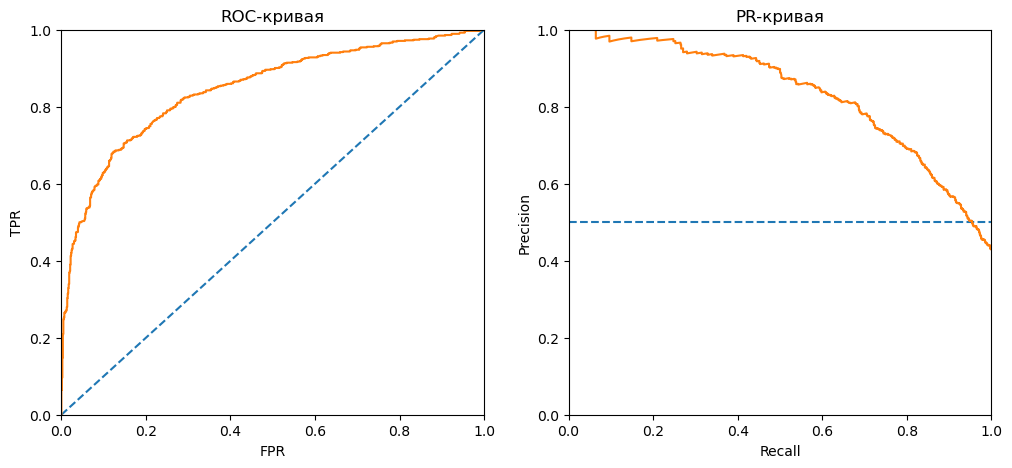

0.32074988

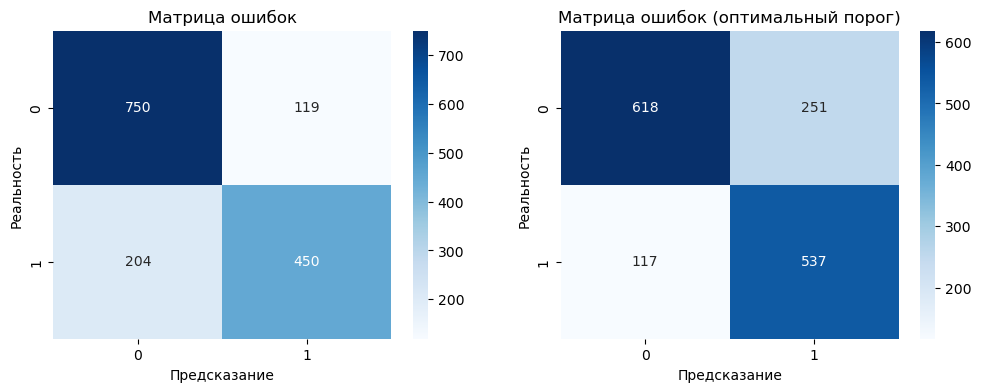

In [71]:
visualize(y_test, best_lr.predict_proba(X_test_embed)[:,1])

## Проекция на меньшую размерность

In [72]:
from matplotlib import rcParams
rcParams['font.family'] = ['Noto Sans CJK JP', 'sans-serif']

In [73]:
from sklearn.decomposition import PCA

In [75]:
def plot_w2v(model, w2v=None, save=None):
    if save:
        fig, ax = plt.subplots(figsize=(128,128))
    plt.scatter(model[:, 0], model[:, 1], s=1);
    if save:
        for i, v in enumerate(w2v.vectors[:10000]):
            word = w2v.index_to_key[i]
            plt.annotate(word, (model[i, 0], model[i, 1]))
        plt.savefig(save)

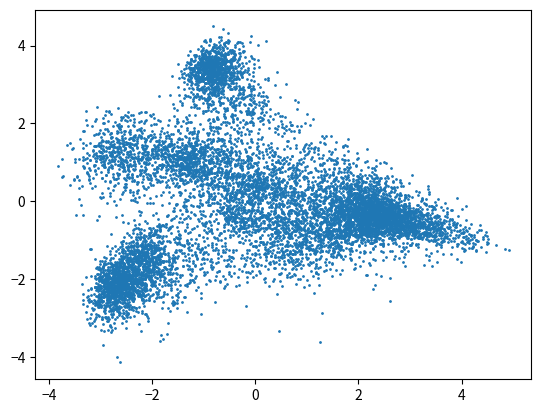

In [76]:
pca = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(model_glove_twitter.vectors[:10000])
plot_w2v(pca)

### t-SNE

In [77]:
from sklearn.manifold import TSNE

In [78]:
tsne = TSNE(n_components=2, metric='cosine', n_jobs=-1, random_state=RANDOM_STATE).fit_transform(model_glove_twitter.vectors[:10000])

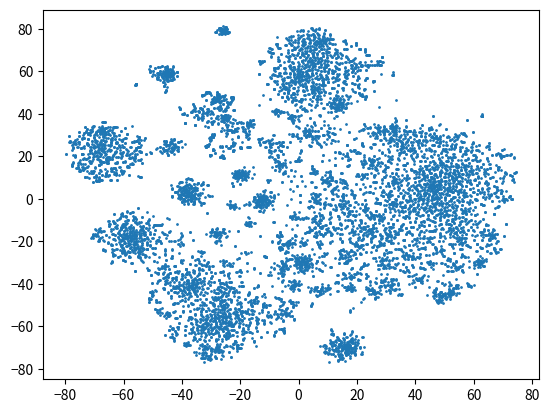

In [79]:
plot_w2v(tsne)

### UMAP

In [80]:
from umap import UMAP

/home/daiyousei/.conda/envs/DS310/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/daiyousei/.conda/envs/DS310/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/daiyousei/.conda/envs/DS310/lib/python3.10/site-packages/umap/dist

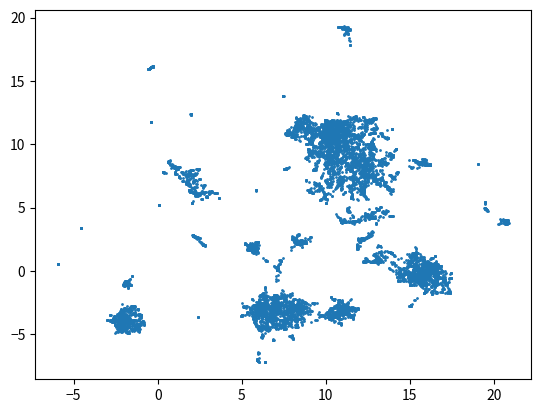

In [81]:
umap = UMAP(n_components=2, metric='cosine', n_neighbors=5, random_state=RANDOM_STATE).fit_transform(model_glove_twitter.vectors[:10000])
plot_w2v(umap)

## Кластеризация

### KMeans

In [82]:
from sklearn.cluster import KMeans

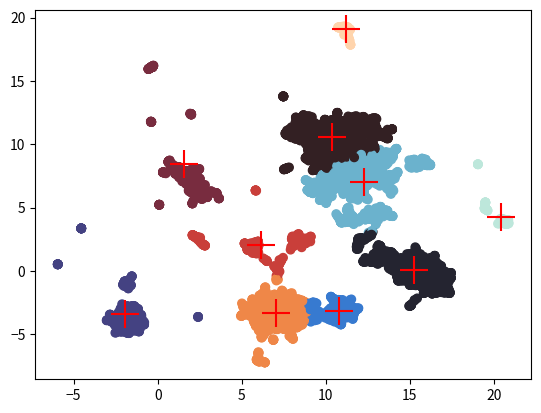

In [227]:
model = KMeans(n_clusters=10, random_state=RANDOM_STATE, n_init='auto')
kmeans = model.fit_predict(umap)
plt.scatter(umap[:, 0], umap[:, 1], c=kmeans, cmap='icefire');
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='+', s=400, color='red');

In [84]:
def elbow_plot(data, method, max_clusters=20):
    metrics = []
    
    for i in range(1, max_clusters+1):
        model = method(n_clusters=i, random_state=RANDOM_STATE, n_init='auto')
        model.fit(data)
        metrics.append(model.inertia_)
    
    plt.plot(range(1, max_clusters+1), metrics)
    plt.title('График локтя')
    plt.xlabel('Число кластеров')
    plt.ylabel('Среднее расстояние до центра')
    plt.xlim((1, max_clusters))
    plt.ylim(0)

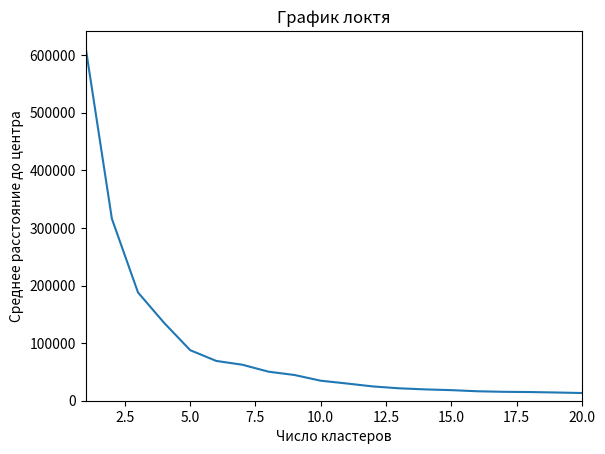

In [85]:
elbow_plot(umap, KMeans)

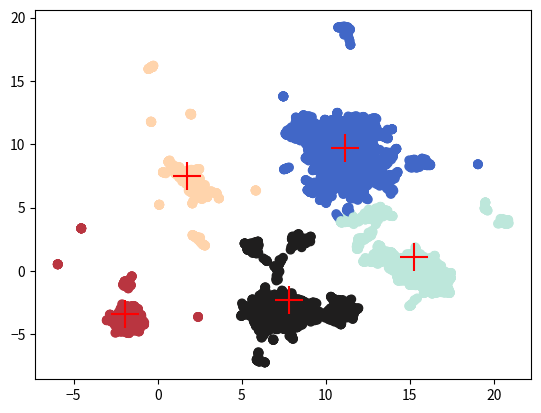

In [228]:
model = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init='auto')
kmeans = model.fit_predict(umap)
plt.scatter(umap[:, 0], umap[:, 1], c=kmeans, cmap='icefire');
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='+', s=400, color='red');

### Иерархическая кластеризация

In [87]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
hier.

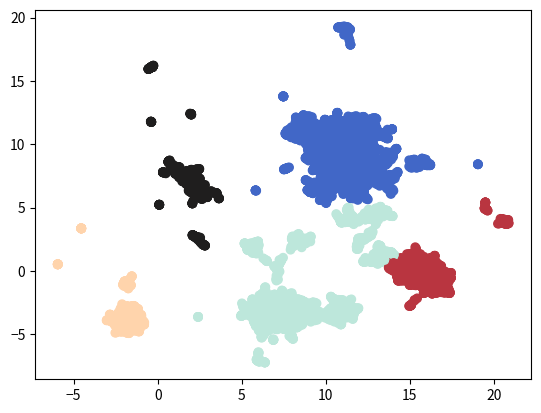

In [231]:
hier = AgglomerativeClustering(n_clusters=5)
agg_result = hier.fit_predict(umap)
plt.scatter(umap[:, 0], umap[:, 1], c=agg_result, cmap='icefire');

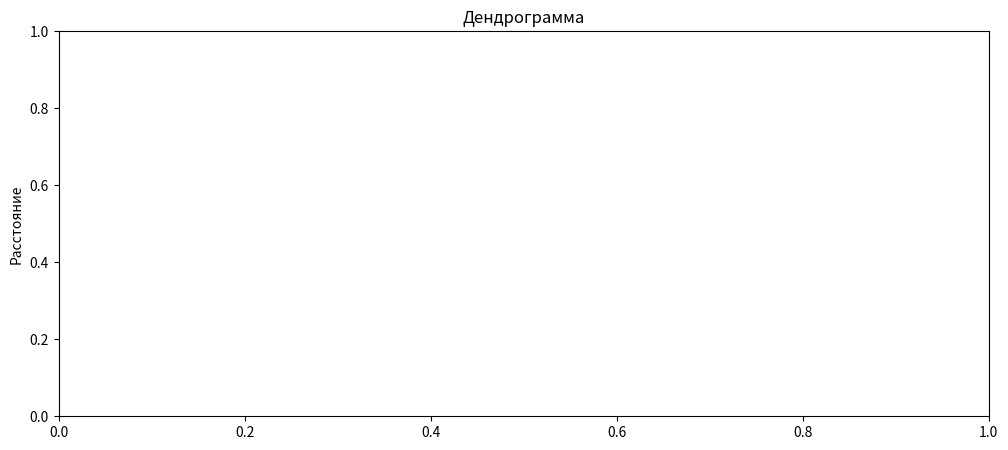

In [89]:
fig, ax = plt.subplots(figsize=(12, 5))
#dendrogram(linkage(umap, method='ward'), truncate_mode='level');
plt.title('Дендрограмма')
plt.ylabel('Расстояние');

### DBSCAN

In [91]:
from sklearn.cluster import DBSCAN

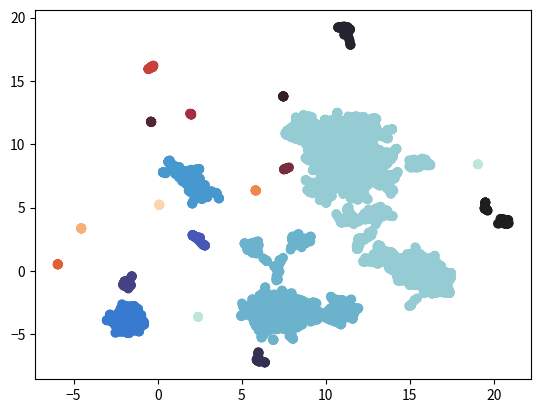

In [233]:
dbscan = DBSCAN(eps=1, min_samples=5, n_jobs=-1)
dbs = dbscan.fit_predict(umap)
plt.scatter(umap[:, 0], umap[:, 1], c=dbs, cmap='icefire');

## Выбросы и аномалии

Мы уже учились выявлять выбросы в рамках отдельных признаков с помощью диаграммы размаха. Здесь мы разберем некоторые продвинутые методы.

In [283]:
df = pd.read_csv('framingham_heart_disease.csv')

In [284]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [286]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4238.0,0.429212,0.495022,0.00,0.00,0.0,1.000,1.0
age,4238.0,49.584946,8.572160,32.00,42.00,49.0,56.000,70.0
education,4133.0,1.978950,1.019791,1.00,1.00,2.0,3.000,4.0
currentSmoker,4238.0,0.494101,0.500024,0.00,0.00,0.0,1.000,1.0
cigsPerDay,4209.0,9.003089,11.920094,0.00,0.00,0.0,20.000,70.0
BPMeds,4185.0,0.029630,0.169584,0.00,0.00,0.0,0.000,1.0
prevalentStroke,4238.0,0.005899,0.076587,0.00,0.00,0.0,0.000,1.0
prevalentHyp,4238.0,0.310524,0.462763,0.00,0.00,0.0,1.000,1.0
diabetes,4238.0,0.025720,0.158316,0.00,0.00,0.0,0.000,1.0
totChol,4188.0,236.721585,44.590334,107.00,206.00,234.0,263.000,696.0


In [287]:
df = df.dropna()

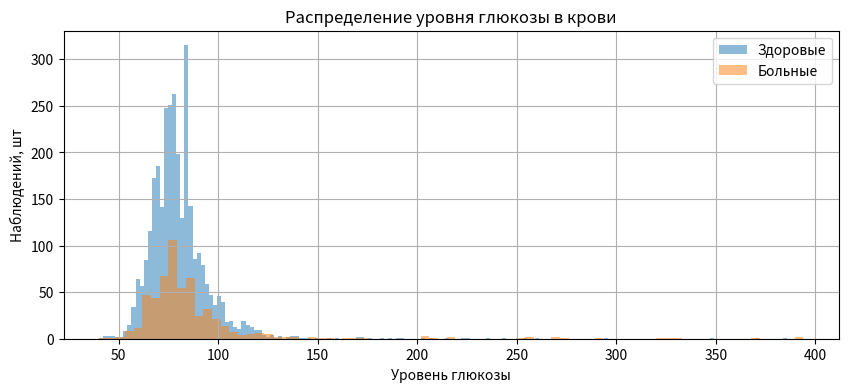

In [288]:
_, ax = df.groupby('TenYearCHD')['glucose'].hist(bins='fd', figsize=(10,4), alpha=0.5);
ax.set(xlabel='Уровень глюкозы', ylabel='Наблюдений, шт', title='Распределение уровня глюкозы в крови')
ax.legend(['Здоровые', 'Больные']);

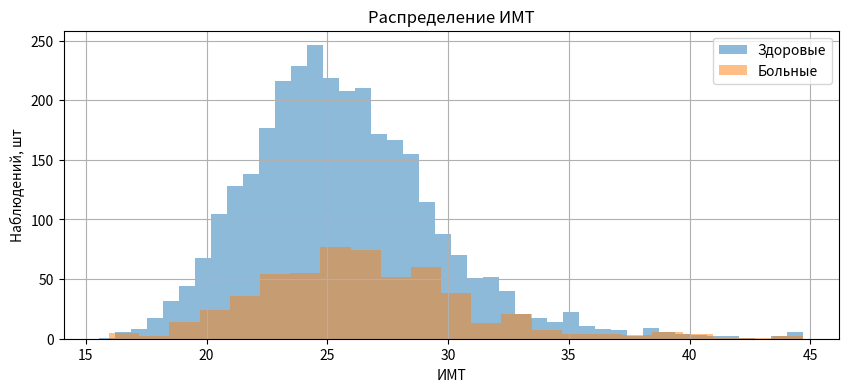

In [270]:
_, ax = df.groupby('TenYearCHD')['BMI'].hist(bins='fd', figsize=(10,4), alpha=0.5);
ax.set(xlabel='ИМТ', ylabel='Наблюдений, шт', title='Распределение ИМТ')
ax.legend(['Здоровые', 'Больные']);

### Применение функций расстояния

In [254]:
outlier_space = ['BMI', 'glucose']

# Матрица ковариации:
covariance = np.cov(df[outlier_space], rowvar=False)
inv_covariance = np.linalg.inv(covariance)

# Центр:
center = np.mean(df[outlier_space], axis=0)

In [255]:
from scipy.spatial.distance import mahalanobis

def calc_distance(row):
    return mahalanobis(row, center, inv_covariance)

In [256]:
distance = df[outlier_space].apply(calc_distance, axis=1)

In [259]:
# Отсекаем 1% выбросов:
limit = distance.quantile(0.99)

In [260]:
from matplotlib.patches import Ellipse

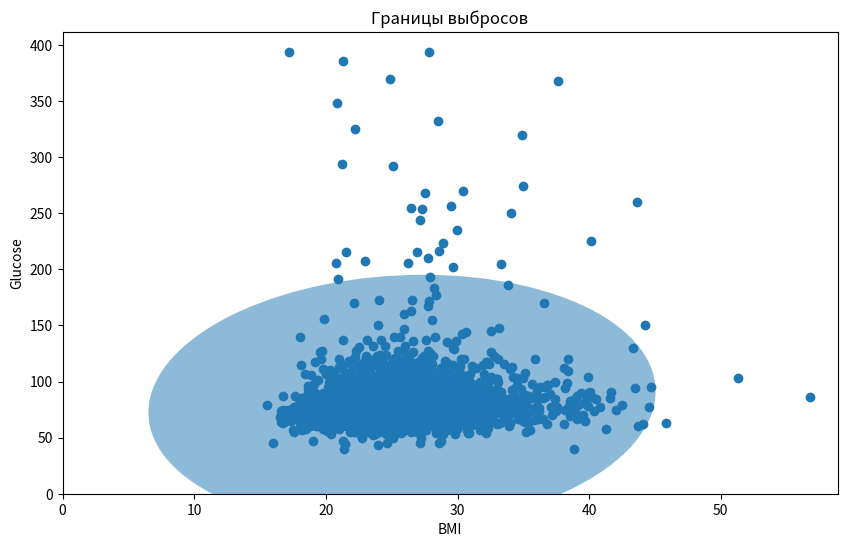

In [261]:
lambda_, v = np.linalg.eig(covariance)
lambda_ = np.sqrt(lambda_)
ellipse = Ellipse(xy=(center[0], center[1]),
                  width=lambda_[0] * limit * 2, height=lambda_[1] * limit * 2,
                  angle=np.rad2deg(np.arccos(v[0, 0])))
ellipse.set_alpha(0.5)
fig = plt.figure(figsize=(10,6))
ax = plt.subplot()
plt.scatter(x=df['BMI'], y=df['glucose']);
ax.add_artist(ellipse)
ax.set(xlim=(0), ylim=(0), title='Границы выбросов', xlabel='BMI', ylabel='Glucose');

In [267]:
# Comment this out to test without outlier exclusion:
df[distance < limit][outlier_space].agg(['min', 'max']).T

,min,max
BMI,15.54,44.71
glucose,40.00,193.00


In [268]:
# df['BMI'] = df['BMI'].apply(lambda x: np.clip(x, 15.54, 44.71))
# df['glucose'] = df['glucose'].apply(lambda x: np.clip(x, 40, 193))

### Изоляционный лес

In [271]:
from sklearn.ensemble import IsolationForest

In [307]:
isolation_forest = IsolationForest(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, contamination=0.01) 
outliers = isolation_forest.fit_predict(df)

/home/daiyousei/.conda/envs/DS310/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [308]:
df[outliers==-1].head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,outlier
37,1,52,1.0,0,0.0,0.0,0,1,1,178.0,160.0,98.0,40.11,75.0,225.0,0,1
44,0,53,3.0,0,0.0,1.0,0,1,1,311.0,206.0,92.0,21.51,76.0,215.0,1,1
66,0,62,1.0,0,0.0,0.0,0,1,1,212.0,190.0,99.0,29.64,100.0,202.0,0,1
249,0,60,1.0,1,20.0,0.0,0,0,1,180.0,200.0,122.5,44.27,88.0,150.0,0,1
471,1,61,1.0,0,0.0,1.0,0,1,1,270.0,177.5,95.0,28.15,62.0,123.0,1,0


### Метод ближайших соседей для поиска аномалий

In [293]:
from pyod.models.knn import KNN

In [303]:
outliers = KNN(contamination=0.01, n_jobs=-1).fit_predict(df) 

/home/daiyousei/.conda/envs/DS310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [306]:
df[outliers==1].head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,outlier
37,1,52,1.0,0,0.0,0.0,0,1,1,178.0,160.0,98.0,40.11,75.0,225.0,0,1
44,0,53,3.0,0,0.0,1.0,0,1,1,311.0,206.0,92.0,21.51,76.0,215.0,1,1
66,0,62,1.0,0,0.0,0.0,0,1,1,212.0,190.0,99.0,29.64,100.0,202.0,0,1
194,0,42,3.0,0,0.0,0.0,0,0,0,464.0,128.0,87.0,22.90,72.0,72.0,1,1
249,0,60,1.0,1,20.0,0.0,0,0,1,180.0,200.0,122.5,44.27,88.0,150.0,0,1


# Домашнее задание

## Easy

Вернитесь к любому датасету с категориальными признаками, над которым мы работали (или скачайте новый с интернета). Предложите оптимальный метод кодирования признаков. Реализуйте его (достаточно `.fit_transform()`).

In [234]:
# Ваш код ниже:


## Normal

Изучите эмбеддинги word2vec, обученные на википедии:

In [ ]:
model_wiki = api.load("glove-wiki-gigaword-300")

Вы можете также воспользоваться другой предобученной моделью или найти ее в интернете:

In [150]:
list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

1. Спроецируйте эмбеддинги на плоскость. Возможно, вам придется перебрать несколько методов и гиперпараметров, чтобы получить более показательную картину.

In [221]:
# Ваш код ниже:


2. Попробуйте выделить кластеры методом DBSCAN. Сделайте вывод по наблюдениям. Насколько вы довольны результатом?

In [222]:
# Ваш код ниже:


Сохранить визуализацию в файл можно с помощью написанной выше функции `plot_w2v(my_umap, w2v=model_wiki, save='file.png')`.

## Hard

Попробуйте реализовать простую модель Word2Vec методом градиентного спуска. Обучающую выборку возьмите по своему усмотрению.

Вам понадобится:

- сделать one-hot encoding слов (`CountVectorizer` подойдет);
- придумать, как легко определять, в одном ли контексте слова, и обучать на соответствующих парах;
- возможно, собирать вектор контекста для слова;
- обучить матрицу эмбеддингов: если слово встречается в контексте, вектора должны быть похожи, если нет - ортогональны.

Изучите полученные эмбеддинги. Довольны ли вы результатом?